In [2]:
!pip install -q yfinance
!pip install -q hmmlearn

     |████████████████████████████████| 6.3MB 3.1MB/s 
     |████████████████████████████████| 378kB 2.0MB/s 


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tqdm
from sklearn import preprocessing, mixture
from hmmlearn import hmm
import yfinance as yf

In [4]:
banco = yf.Ticker("BAMI.MI")

In [5]:

hist = banco.history(period='max')
hist['Daily Return'] = np.log(hist['Close'] / hist['Close'].shift(1))
hist = hist.loc['1999-01-01':]
hist.reset_index(inplace = True)
# hist = hist.set_index('Date')
# print(hist.head())
print(hist)

           Date       Open       High  ...  Dividends  Stock Splits  Daily Return
0    2000-01-03  66.776240  69.215813  ...        0.0           0.0           NaN
1    2000-01-04  68.081120  68.081120  ...        0.0           0.0     -0.023650
2    2000-01-05  65.811750  65.811750  ...        0.0           0.0     -0.026853
3    2000-01-06  64.960727  64.960727  ...        0.0           0.0      0.004380
4    2000-01-07  65.301144  67.230110  ...        0.0           0.0      0.021618
...         ...        ...        ...  ...        ...           ...           ...
5468 2021-05-27   2.835000   2.917000  ...        0.0           0.0      0.025468
5469 2021-05-28   2.910000   2.925000  ...        0.0           0.0      0.001033
5470 2021-05-31   2.915000   2.963000  ...        0.0           0.0      0.007542
5471 2021-06-01   2.940000   2.966000  ...        0.0           0.0      0.010194
5472 2021-06-02   2.960000   2.970000  ...        0.0           0.0     -0.005084

[5473 rows x 9 

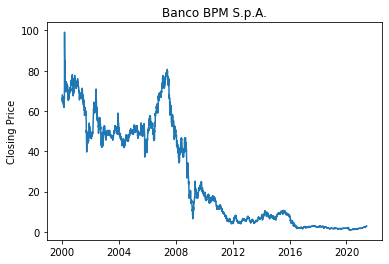

In [6]:
hist2=hist
hist2.index=hist2.Date
plt.title('Banco BPM S.p.A.')
plt.ylabel('Closing Price')
close = plt.plot(hist2['Close'])

In [7]:
num_ID = 30000

In [8]:
features = []

In [9]:
window = np.random.randint(20,40)

In [10]:
window

34

In [16]:
num_ID = 30000
features = []
for i in tqdm.tqdm(range(num_ID)):
    window = np.random.randint(20,40)
    start_ind = np.random.randint(0, len(hist) - window)
    watch = hist.iloc[start_ind : start_ind + window]
    end_date = max(watch['Date'])
    volume_change = watch['Volume'].pct_change()
    exc_high = (watch['High'] - watch['Open']) / watch['Open']
    exc_low = (watch['Open'] - watch['Low']) / watch['Low']
    daily_change = (watch['Close'] - watch['Open']) / watch['Open']
    forcast = (watch['Open'].shift(-1) - watch['Open'])
    logret_w1 = np.log(watch['Close']/watch['Close'].shift(1))
    close = watch['Close']
    features.append(pd.DataFrame({'ID': [i] * window,
                                  'Window Size': [window] * window,
                                  'End Date': [end_date] * window,
                                  'Volume Change': volume_change,
                                  'Excessive High': exc_high,
                                  'Excessive Low': exc_low,
                                  'Daily Change': daily_change,
                                  'Daily Return': logret_w1,
                                  'Forcasted Change': forcast,
                                  'Close': close}))
featured = pd.concat(features)

100%|██████████| 30000/30000 [02:06<00:00, 237.40it/s]


In [44]:
featured = featured.dropna(how = 'any')
featured

,ID,Window Size,End Date,Volume Change,Excessive High,Excessive Low,Daily Change,Daily Return,Forcasted Change,Close
Date,,,,,,,,,,
2011-09-14,0,25,2011-10-17,-0.062033,0.072642,0.002838,0.065094,0.049942,0.391802,5.599297
2011-09-15,0,25,2011-10-17,0.727591,0.057946,0.020609,0.007024,0.015818,0.322368,5.688568
2011-09-16,0,25,2011-10-17,0.422317,0.000000,0.046047,-0.011628,0.036804,-0.267813,5.901827
2011-09-19,0,25,2011-10-17,-0.446526,0.073043,0.000000,0.049565,0.014185,0.148785,5.986139
2011-09-20,0,25,2011-10-17,-0.083237,0.053390,0.004255,0.042373,0.018876,0.267814,6.100207
...,...,...,...,...,...,...,...,...,...,...
2001-09-25,29999,27,2001-10-02,-0.521055,0.047486,0.031700,0.019553,0.016575,1.134679,41.416016
2001-09-26,29999,27,2001-10-02,1.574363,0.085598,0.008219,0.085598,0.090316,5.219563,45.330673
2001-09-27,29999,27,2001-10-02,-0.618327,0.000000,0.098143,-0.032609,0.002500,-1.531825,45.444153


In [18]:
compact = featured.groupby(['ID','End Date']).agg('mean').reset_index()
compact.set_index('End Date', inplace=True)
compact = compact.sort_index()
compact.index = pd.to_datetime(compact.index)
compact

,ID,Window Size,Volume Change,Excessive High,Excessive Low,Daily Change,Daily Return,Forcasted Change,Close
End Date,,,,,,,,,
2000-01-31,6254,21,0.376595,0.010671,0.017935,-0.004178,-0.001245,-0.220965,65.758000
2000-02-03,8739,20,0.192914,0.010264,0.016603,-0.005053,-0.001885,-0.066190,65.512319
2000-02-03,5192,22,0.360912,0.010714,0.015162,-0.003810,-0.000397,0.039715,65.522404
2000-02-04,22459,23,0.337320,0.010204,0.015879,-0.004655,-0.000209,0.013509,65.465941
2000-02-04,4803,22,0.401539,0.010714,0.016454,-0.004845,-0.000439,-0.002837,65.494038
...,...,...,...,...,...,...,...,...,...
2021-05-31,4308,37,0.081869,0.015035,0.013125,0.003668,0.006981,0.018227,2.502728
2021-05-31,2200,38,0.074163,0.014853,0.013265,0.003319,0.006479,0.017179,2.496432
2021-05-31,10401,37,0.081869,0.015035,0.013125,0.003668,0.006981,0.018227,2.502728


In [19]:

def norm(data):
    data = preprocessing.scale(data)
    return data

In [20]:
compact=compact[~compact.isin([np.nan, np.inf, -np.inf]).any(1)]

In [21]:
X = pd.DataFrame()
X['Close'] = norm(compact['Close'].values)
X['Daily Change'] = norm(compact['Daily Change'].values)
X['Volume Change'] = norm(compact['Volume Change'].values)
X['Excessive High'] = norm(compact['Excessive High'].values)
X['Excessive Low'] = norm(compact['Excessive Low'].values)
X['Forcasted Change'] = norm(compact['Forcasted Change'].values)
X['Daily Return'] = norm(compact['Daily Return'].values)
X.index = compact.index
X = X.reset_index()
features = ['Close', 'Daily Change', 'Volume Change', 'Excessive High', 'Excessive Low', 'Forcasted Change', 'Daily Return' ]

In [43]:
print(X.shape)
X

(25247, 8)


,End Date,Close,Daily Change,Volume Change,Excessive High,Excessive Low,Forcasted Change,Daily Return
0,2000-01-31,1.918400,-0.452962,1.477409,-0.853915,-0.217453,-1.530245,-0.104715
1,2000-02-03,1.907721,-0.607075,0.279511,-0.905721,-0.346555,-0.401066,-0.208160
2,2000-02-03,1.908159,-0.388231,1.375130,-0.848346,-0.486292,0.371573,0.032293
3,2000-02-04,1.905704,-0.537063,1.221274,-0.913309,-0.416750,0.180384,0.062529
4,2000-02-04,1.906926,-0.570341,1.640084,-0.848346,-0.361024,0.061134,0.025457
...,...,...,...,...,...,...,...,...
25242,2021-05-31,-0.831339,0.927673,-0.444681,-0.298233,-0.683846,0.214805,1.224093
25243,2021-05-31,-0.831613,0.866172,-0.494934,-0.321385,-0.670309,0.207161,1.143075
25244,2021-05-31,-0.831339,0.927673,-0.444681,-0.298233,-0.683846,0.214805,1.224093
25245,2021-06-01,-0.826947,1.336316,-0.136327,-0.138287,-0.815129,0.273760,1.708136


In [23]:
def get_best_hmm_model(data, max_states, max_iter = 10000):
    best_score = -(10 ** 10)
    best_state = 0
    
    for state in tqdm.tqdm(range(1, max_states + 1)):
        hmm_model = hmm.GaussianHMM(n_components = state, random_state = 100, covariance_type = 'diag', \
                                n_iter = max_iter).fit(data)
        if hmm_model.score(data) >= best_score:
            best_score = hmm_model.score(data)
            best_state = state
            
    best_model = hmm.GaussianHMM(n_components = best_state, random_state = 100, covariance_type = 'diag', \
                            n_iter = max_iter).fit(data)
    
    return best_model

In [24]:
def get_best_gmm_model(data, min_states, max_states):
    bic = []
    aic = []
#     aic = np.asarray([])
    window = 100
    num_obs = 400
    assert(window < num_ID)
    
    for i in tqdm.tqdm(range(min_states, max_states+1)):
        state_bic = []
        state_aic = []
        end_ind = len(data) - 1 - num_obs
        start_ind = end_ind - window
#         end_ind = start_ind + num_observations - 1
        counter = 0
        while counter < num_obs:
            curr_data = data[start_ind : end_ind + 1]
            gmm_model = mixture.GaussianMixture(n_components=i, covariance_type='diag').fit(curr_data)
            curr_bic = gmm_model.bic(curr_data)
            curr_aic = gmm_model.aic(curr_data)
            state_bic.append(curr_bic)
            state_aic.append(curr_aic)
            start_ind += 1
            end_ind += 1
            counter += 1
        
        bic.append(state_bic)
        aic.append(state_aic)

    return bic, aic, max_states


In [25]:
train_X = X[features].values
model = get_best_hmm_model(train_X, 6, 10000)
model

100%|██████████| 6/6 [00:45<00:00,  7.64s/it]


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10000, params='stmc',
            random_state=100, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
            verbose=False)

In [26]:
min_states = 2
max_states = 4
bic, aic, states= get_best_gmm_model(np.asarray(compact['Daily Return']).reshape(-1,1), min_states, max_states)

100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


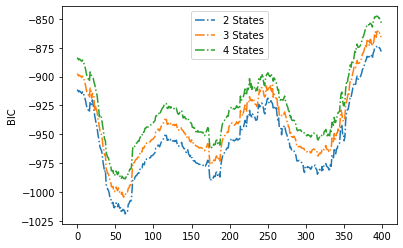

In [27]:
leg = []
i = min_states
for elem in bic:
    plt.plot(elem, linestyle = '-.')
    plt.ylabel("BIC")
    leg.append('{0} States'.format(i))
    plt.legend(leg)
    i += 1

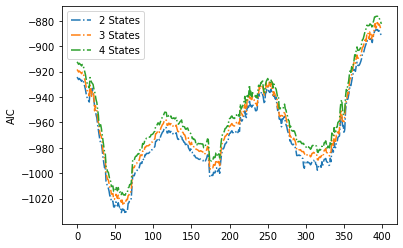

In [28]:
leg = []
i = min_states
for elem in aic:
    plt.plot(elem, linestyle = '-.')
    plt.ylabel("AIC")
    leg.append('{0} States'.format(i))
    plt.legend(leg)
    i += 1

In [29]:

hidden_states = model.predict(train_X)
hidden_states

array([3, 3, 3, ..., 1, 1, 1])

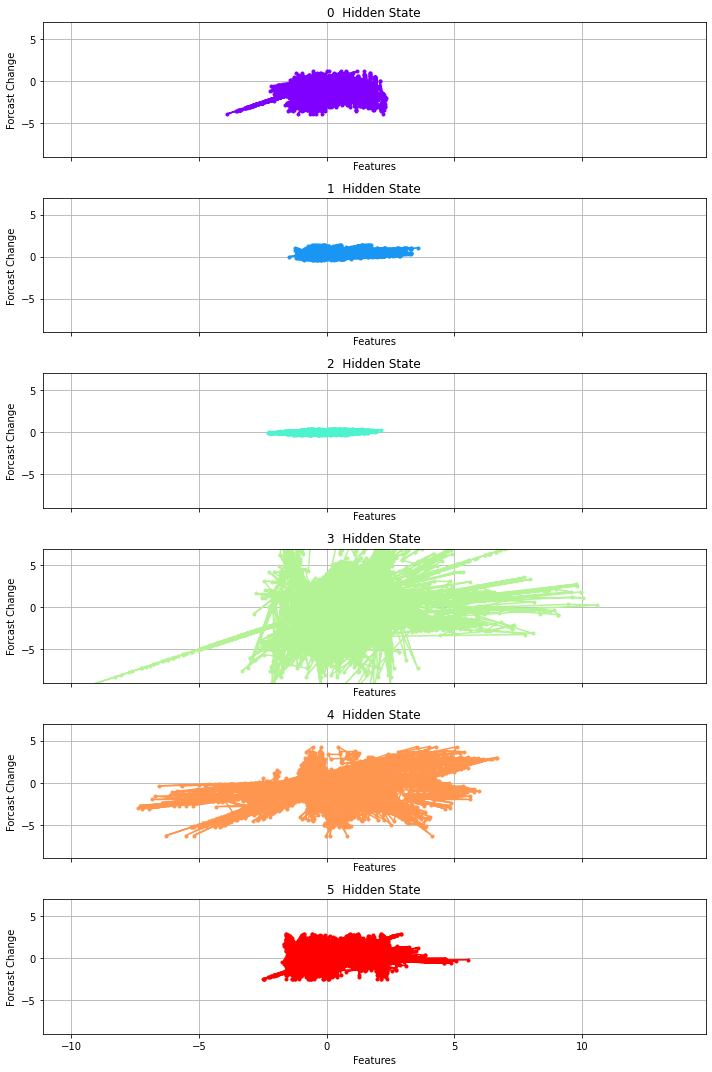

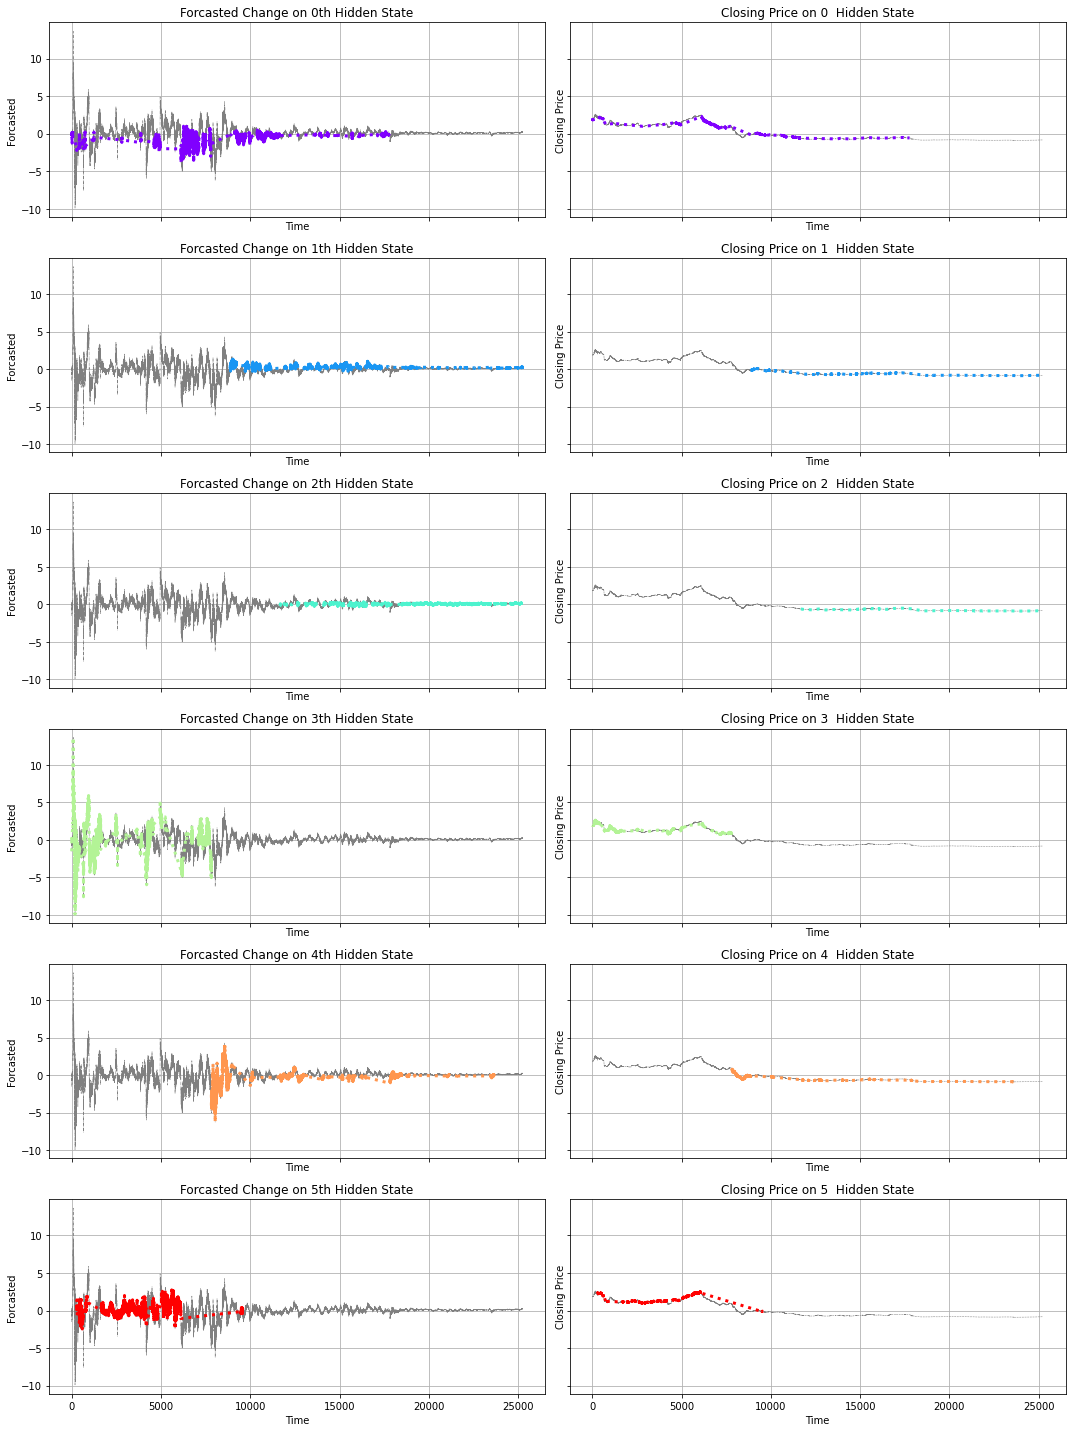

In [30]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(10,15))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, color) in enumerate(zip(axs, colors)):
    mask = (hidden_states == i)
    ax.set_title("{0}  Hidden State".format(i))
    ax.plot(train_X[mask], X['Forcasted Change'][mask], '.-', c = color)
    ax.set_xlabel('Features')
    ax.set_ylabel('Forcast Change')
    ax.set_ylim(-9,7)
    ax.grid(True)
    plt.tight_layout()

fig, axs = plt.subplots(model.n_components, 2, sharex=True, sharey=True, figsize=(15,20))
for i, (ax, color) in enumerate(zip(axs, colors)):
    mask = (hidden_states == i)
    ax[0].set_title("Forcasted Change on {0}th Hidden State".format(i))
    ax[0].plot(X.index, X['Forcasted Change'], c = 'grey', linewidth = 0.5, linestyle = '-.')
    ax[0].plot(X.index[mask], X['Forcasted Change'][mask], c = color, linewidth = 3, linestyle = ':')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Forcasted')
    ax[0].grid(True)

    ax[1].set_title("Closing Price on {0}  Hidden State".format(i))
    ax[1].plot(X.index, X['Close'], c = 'grey', linewidth = 0.5, linestyle = '--')
    ax[1].plot(X.index[mask], X['Close'][mask], c = color, linewidth = 3, linestyle = ':')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Closing Price')
    ax[1].grid(True)

plt.tight_layout()

In [31]:
print("Transition matrix - probability of going to any particular state")
print(model.transmat_)
print(model.predict_proba)

print("Means and vars of each hidden state")
params = pd.DataFrame(columns=('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i],np.diag(model.covars_[i])]

Transition matrix - probability of going to any particular state
[[9.81539675e-001 6.09275925e-003 4.22215450e-003 3.59672962e-003
  1.66323673e-003 2.88544496e-003]
 [5.60103094e-003 9.79466703e-001 1.38426061e-002 3.66270360e-162
  1.08965967e-003 1.45150925e-145]
 [2.26364314e-003 8.88920804e-003 9.82628081e-001 6.94819738e-287
  6.21906817e-003 8.34602865e-272]
 [4.84087029e-003 1.44457383e-211 8.30537272e-269 9.85657892e-001
  4.01640656e-004 9.09959688e-003]
 [3.16310984e-004 2.82564922e-003 1.19319938e-002 1.04942319e-220
  9.84926046e-001 2.72514408e-251]
 [2.80003401e-003 1.15163627e-171 6.52988281e-229 5.57989181e-003
  7.59639979e-297 9.91620074e-001]]
<bound method _BaseHMM.predict_proba of GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10000, params='stmc',
            random_state=100, startprob_prior=1.0, tol=0.0

In [32]:
import datetime

quotes=hist
quotes['Date'] = quotes['Date'].apply(datetime.datetime.toordinal)
quotes = list(quotes.itertuples(index=False, name=None))


In [33]:
lastN = 25
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) #even beyond N days
end_date = datetime.date.today() 

dates = np.array([q[0] for q in quotes], dtype=int)

In [34]:
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[4] for q in quotes])
volume = np.array([q[5] for q in quotes])[1:]

In [35]:
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[4]
expected_volumes = returns_and_volume_columnwise[5]

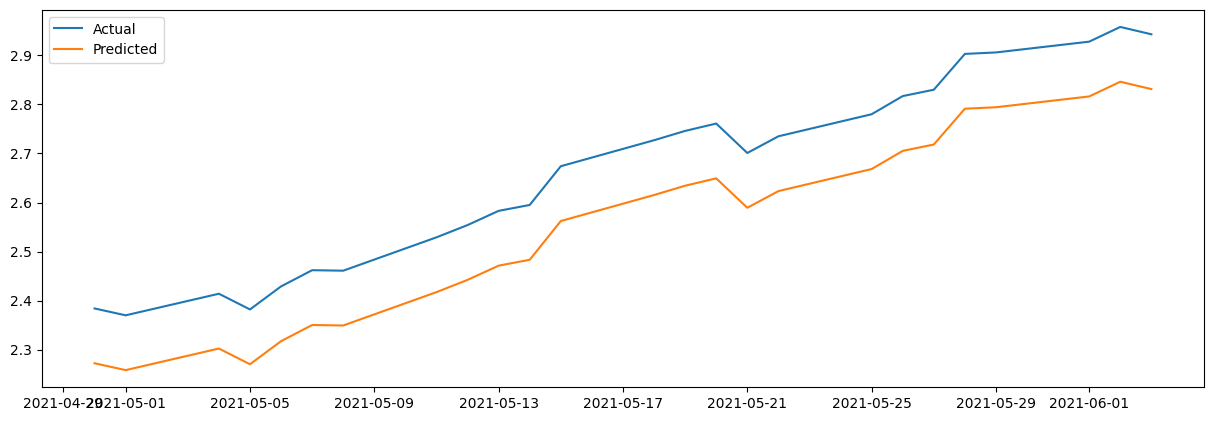

In [48]:

predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = quotes[-lastN+idx][4]
    volume = quotes[-lastN+idx][5]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

# 
plt.figure(figsize=(15, 5), dpi=100) 
plt.plot(predicted_dates,close_v[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()



Forecasting Techniq Metrics Forecasting error, mse, rmse, bias¶


In [37]:
import math,statistics

In [38]:
Actual=close_v[-lastN:]

In [39]:
#predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
forecast_errors = [Actual[i]- predicted_prices[i] for i in range(len(predicted_prices))]
#print('Forecast Errors: %s' % forecast_errors)
mean_forecast_error = statistics.mean(forecast_errors)
mean_forecast_error

0.11173324506872451

In [40]:
bias = sum(forecast_errors) * 1.0/len(predicted_prices)
print('Bias: %f' % bias)

Bias: 0.111733


In [41]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Actual, predicted_prices)
print('MSE: %f' % mse)

MSE: 0.012484


In [42]:
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.111733
